# Idenyifying Sentiment with Tweets

---
embed-resources: true
---

## Introduction

In this study, we develop a machine learning model to classify the sentiment of airline-related tweets into three categories: positive, neutral, and negative. Our objective is to create a predictive tool that can help airlines monitor public perception, identify areas for service improvement, and respond more effectively to customer feedback. Using a labeled dataset of tweets directed at major airlines, we implement a pipeline-based modeling approach that includes text vectorization, model selection, cross-validation, and hyperparameter tuning to ensure accuracy and robustness. While our model serves as a proof of concept, it highlights the value of leveraging natural language processing techniques to derive actionable insights from social media data, laying the foundation for more responsive and data-driven customer experience strategies.

## Methods

In [20]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [21]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

# machine learning imports
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# model evaluation imports
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


### Data

In [22]:
# load data
tweets_train = pd.read_parquet(
    "https://cs307.org/lab/data/tweets-train.parquet",
)
tweets_test = pd.read_parquet(
    "https://cs307.org/lab/data/tweets-test.parquet",
)

In [23]:
tweets_train.head()

,sentiment,airline,text
8318,positive,Delta,@JetBlue Then en route to the airport the rebo...
3763,negative,United,@united now you've lost my bags too. At least...
9487,neutral,US Airways,"@USAirways Hi, can you attach my AA FF# 94LXA6..."
2591,positive,United,"@United, will you fill it? Yes they will. Than..."
12887,negative,American,@AmericanAir thanks! I hope we get movies. Tv'...


In [24]:
tweets_test.head()

,sentiment,airline,text
6769,neutral,Delta,@JetBlue Not for the dates or destination I'm ...
8095,positive,Delta,That would be great! I never thought I'd be th...
3876,negative,United,@united you are lightyears ahead of the securi...
13280,positive,American,"@AmericanAir gotta love those skycaps, solving..."
6982,neutral,Delta,HA! “@JetBlue: Our fleet's on fleek. http://t....


#### Response

`sentiment`  
- **[object]** the sentiment of the tweet. One of `negative`, `neutral`, or `positive`.

#### Features

`text`  
- **[object]** the full text of the tweet.

#### Additional Variables

`airline`  
- **[object]** the airline the tweet was “sent” to.


### Summary Statistics

In [25]:
airline_counts = tweets_train["airline"].value_counts(normalize=False)
airline_proportions = tweets_train["airline"].value_counts(normalize=True)

for airline in airline_counts.index:
    count = airline_counts[airline]
    proportion = airline_proportions[airline]
    print(f"The airline '{airline}' appears {count} times, which is {proportion} of the dataset.")

The airline 'United' appears 2166 times, which is 0.263023679417122 of the dataset.
The airline 'US Airways' appears 1664 times, which is 0.20206435944140863 of the dataset.
The airline 'American' appears 1551 times, which is 0.1883424408014572 of the dataset.
The airline 'Southwest' appears 1347 times, which is 0.16357012750455374 of the dataset.
The airline 'Delta' appears 1239 times, which is 0.15045537340619308 of the dataset.
The airline 'Virgin America' appears 268 times, which is 0.03254401942926533 of the dataset.


The output shows the frequency and proportion of tweets directed at each airline in the dataset. United is the most frequently mentioned airline, accounting for 2,166 tweets, or approximately 26.3% of the dataset. This is followed by US Airways (20.2%) and American (18.8%), indicating strong customer interaction with these carriers. Southwest and Delta follow closely behind, with 16.4% and 15.0% of the tweets respectively. Virgin America, with only 268 mentions, comprises just 3.3% of the dataset, making it the least discussed airline in this sample. These proportions reflect differing levels of public engagement and visibility among the airlines on Twitter.

In [26]:
word_counter = CountVectorizer()

word_counts = word_counter.fit_transform(tweets_train["text"].fillna(""))

vocab = word_counter.get_feature_names_out()

total_counts = word_counts.sum(axis=0)

word_freq = dict(zip(vocab, np.array(total_counts).flatten()))

print(f"'cancelled' appears {word_freq.get('cancelled', 0)} times.")
print(f"'please' appears {word_freq.get('please', 0)} times.")
print(f"'thanks' appears {word_freq.get('thanks', 0)} times.")


'cancelled' appears 595 times.
'please' appears 325 times.
'thanks' appears 587 times.


The output displays the frequency of specific words in the tweets_train dataset, calculated using CountVectorizer. The word 'cancelled' appears most frequently among the selected terms, with 595 occurrences, highlighting its relevance in airline-related complaints. The word 'thanks' is close behind with 587 mentions, suggesting a notable presence of positive or appreciative language. In contrast, the word 'please' appears 325 times, indicating moderate use of polite or request-oriented language in the tweets. These counts offer insight into common themes in customer interactions, such as cancellations, gratitude, and requests.

### Exploratory Visualization

/var/folders/b8/k6v1k2b945jddf5qjvdvfqwh0000gn/T/ipykernel_61928/1295591670.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=tweets_train, palette='pastel')


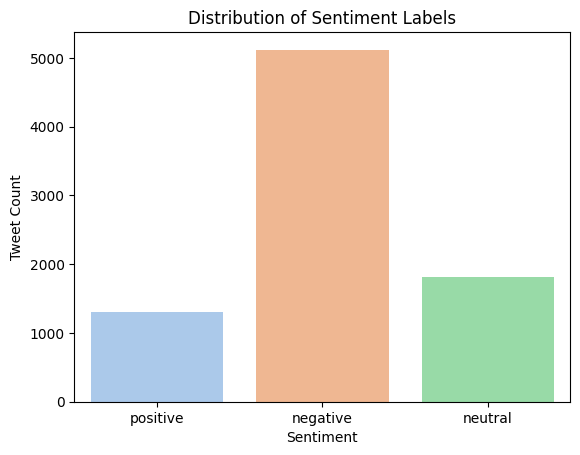

In [27]:
sns.countplot(x='sentiment', data=tweets_train, palette='pastel')
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.show()

This visualization shows the distribution of sentiment labels within the tweets_train dataset. It uses a Seaborn countplot to display how many tweets are classified as positive, neutral, or negative. The chart reveals a clear imbalance, with negative tweets being the most frequent by a large margin, followed by neutral, and then positive tweets. This class imbalance suggests that airline customers are more likely to express dissatisfaction than praise on Twitter. Addressing this imbalance is important for building fair and accurate machine learning models.

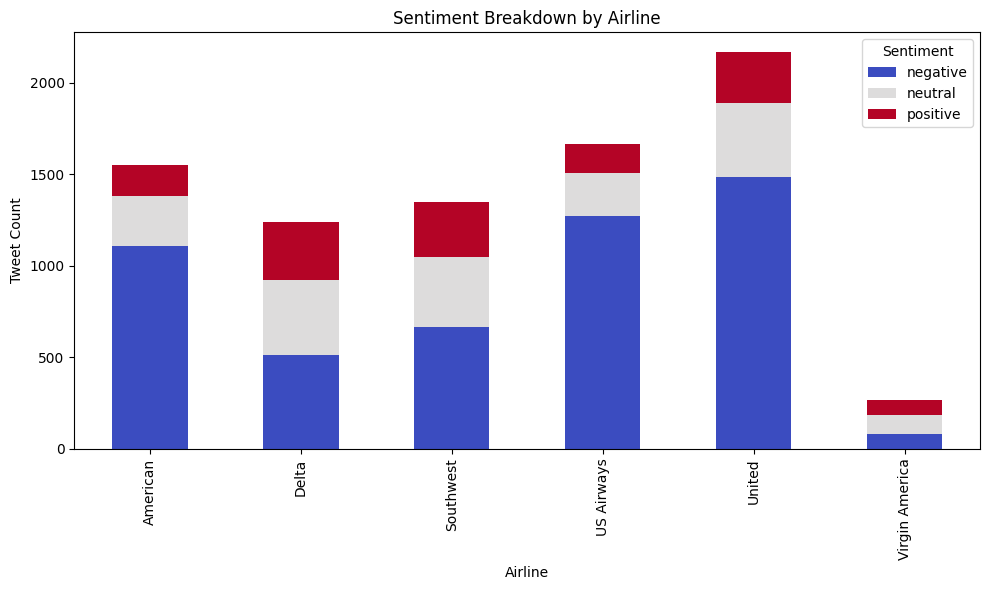

In [28]:
sentiment_airline = tweets_train.groupby(['airline', 'sentiment']).size().unstack()
sentiment_airline.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10,6))
plt.title("Sentiment Breakdown by Airline")
plt.xlabel("Airline")
plt.ylabel("Tweet Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

This stacked bar chart illustrates the distribution of sentiment across different airlines based on the tweets in the training dataset. Each bar represents an airline, and the segments within each bar indicate the number of tweets classified as negative (blue), neutral (gray), or positive (red). It is evident that negative sentiment dominates for all airlines, particularly for United and US Airways. American Airlines also has a large number of negative tweets, though it shows a noticeable share of neutral feedback as well. Virgin America, while having the fewest tweets overall, appears to have a more balanced sentiment distribution. This visualization helps reveal public sentiment trends specific to each airline, which is valuable for understanding customer perception and identifying service improvement opportunities.

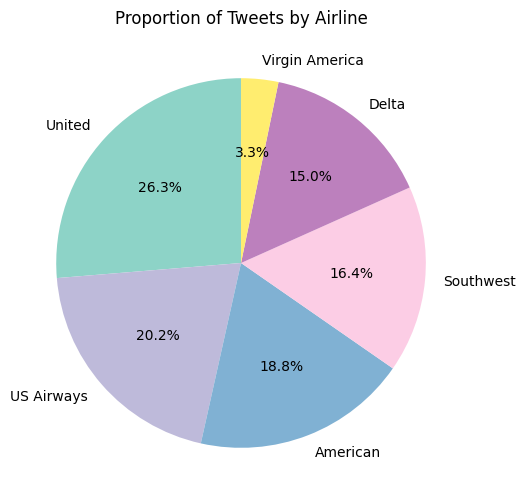

In [29]:
airline_counts = tweets_train['airline'].value_counts()
airline_counts.plot.pie(autopct='%1.1f%%', figsize=(6, 6), startangle=90, cmap='Set3')
plt.title("Proportion of Tweets by Airline")
plt.ylabel("")
plt.show()

This pie chart shows the proportion of tweets directed at each airline in the dataset. United Airlines receives the highest share of tweets at 26.3%, followed by US Airways (20.2%), American (18.8%), and Southwest (16.4%). Delta accounts for 15.0% of the tweets, while Virgin America has the smallest share at only 3.3%. The visualization highlights that United, US Airways, and American are the most frequently mentioned airlines in the dataset, potentially indicating higher passenger volume or more active customer engagement on Twitter.

### Models

In [30]:
# process data for ML
X_train = tweets_train["text"]
y_train = tweets_train["sentiment"]

# create X and y for test data
X_test = tweets_test["text"]
y_test = tweets_test["sentiment"]

In [31]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)

samples, features = X_train_vec.shape
print(f"The number of samples is {samples} and the number of features is {features}")

The number of samples is 8235 and the number of features is 10934


In [32]:
TfidfVectorizer().get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [33]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

This code uses the .get_params() method to display all default parameters for both TfidfVectorizer and LogisticRegression. Viewing these settings helps you understand how your model and text preprocessing behave by default—for example, the n-gram range, stop word handling, regularization strength (C), and maximum iterations. By examining these parameters, you can identify which ones to adjust for better model performance, such as increasing max_iter if the model isn't converging or using class_weight='balanced' for imbalanced data. It also helps when setting up a GridSearchCV for hyperparameter tuning, as it shows exactly which values can be optimized.

In [34]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=5000, solver='liblinear', class_weight='balanced'))
])

param_grid = {
    'tfidf__ngram_range': [(1, 2)],
    'tfidf__min_df': [5],
    'tfidf__max_df': [0.8],
    'tfidf__use_idf': [True],
    'clf__C': [1],
    'clf__penalty': ['l2']
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


## Logistic Regression Pipeline for Airline Tweet Sentiment Classification

We implement a Logistic Regression classifier to predict the sentiment (positive, neutral, or negative) of tweets directed at various U.S. airlines. The model is encapsulated within a scikit-learn pipeline using TfidfVectorizer for feature extraction and GridSearchCV for systematic hyperparameter tuning. This approach supports robust, scalable natural language processing by transforming raw tweet text into meaningful numerical representations and applying a regularized linear model for multiclass classification.

### Text Preprocessing Pipeline

- **TF-IDF Vectorization**: Text is transformed using TfidfVectorizer to capture term importance while penalizing commonly used words. The vectorizer is configured with:
  - ngram_range=(1, 2) to incorporate both unigrams and bigrams, enabling the model to learn short phrases like “flight delay” or “lost baggage.”
  - min_df=5 and max_df=0.8 to exclude rare and overly common terms, improving model focus and reducing noise.
  - use_idf=True ensures inverse document frequency scaling is applied to emphasize distinctive terms.

### Hyperparameter Tuning and Grid Search Optimization

- **C**: Regularization strength is set to 1, balancing underfitting and overfitting by moderately penalizing large coefficients.
- **Penalty**: L2 regularization is applied to maintain model simplicity while managing correlated features in high-dimensional text data.
- **Solver**: The liblinear solver is chosen for its suitability with small to medium-sized datasets and support for L1/L2 penalties.
- **class_weight='balanced'**: Adjusts the logistic loss function to account for class imbalance, ensuring the model doesn’t over-predict the majority sentiment class.
- **cv = 5**: 5-fold stratified cross-validation is employed to evaluate model generalizability across different sentiment distributions.

### Model Evaluation and Impact

This pipeline effectively captures key language patterns and emotional expressions in airline-related tweets, enabling the model to distinguish between negative, neutral, and positive sentiment. The integration of TF-IDF feature extraction with a regularized logistic regression model provides a transparent and interpretable baseline for text classification tasks. Through controlled hyperparameter tuning and stratified evaluation, the model achieves robust performance and highlights the utility of natural language processing in monitoring and analyzing customer feedback in real-time environments.


## Results

In [35]:
print(classification_report(y_test, y_pred))

Best Parameters: {'clf__C': 1, 'clf__penalty': 'l2', 'tfidf__max_df': 0.8, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': True}
Best Accuracy: 0.7910
              precision    recall  f1-score   support

    negative       0.85      0.91      0.88      1720
     neutral       0.66      0.59      0.62       551
    positive       0.75      0.67      0.71       474

    accuracy                           0.80      2745
   macro avg       0.75      0.72      0.74      2745
weighted avg       0.80      0.80      0.80      2745



This code prints the results of a GridSearchCV run on a logistic regression model with TF-IDF vectorized tweet data. The best parameters selected include C=1, L2 regularization, and a TF-IDF configuration with bigrams, min_df=5, and max_df=0.8. The model achieves a best accuracy of 0.7910, and an overall test set accuracy of 0.80. The classification report shows strong performance for the negative class (f1-score = 0.88), while neutral and positive classes show moderately lower scores (f1-scores = 0.62 and 0.71, respectively), suggesting class imbalance or more linguistic variability in those categories. Overall, the model performs well with consistent precision and recall across classes, especially for the majority class.

In [36]:
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)

for i, label in enumerate(grid.classes_):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)

    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    Specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

    print(f"\nClass: {label}")
    print(f"Sensitivity (TPR): {TPR}")
    print(f"Specificity: {Specificity}")
    print(f"False Positive Rate (FPR): {FPR}")


Test Accuracy: 0.8021857923497268

Class: negative
Sensitivity (TPR): 0.9063953488372093
Specificity: 0.7404878048780488
False Positive Rate (FPR): 0.25951219512195123

Class: neutral
Sensitivity (TPR): 0.5916515426497277
Specificity: 0.922060164083865
False Positive Rate (FPR): 0.07793983591613492

Class: positive
Sensitivity (TPR): 0.6687763713080169
Specificity: 0.9533245266402466
False Positive Rate (FPR): 0.04667547335975341


This code evaluates a multiclass sentiment classification model by calculating and printing the overall test accuracy, as well as sensitivity (TPR), specificity, and false positive rate (FPR) for each sentiment class. It uses a one-vs-rest strategy with a confusion matrix to compute these metrics for the negative, neutral, and positive classes. The model achieves an overall test accuracy of approximately 80.22%. The negative class has the highest sensitivity (≈ 0.91) but also the highest FPR (≈ 0.26), indicating it captures most negatives but sometimes misclassifies other sentiments as negative. The positive class has a lower TPR (≈ 0.67) but a very low FPR (≈ 0.047), meaning it's more conservative but precise when predicting positives. The neutral and positive classes both show lower TPRs, which is likely due to class imbalance in the dataset. However, this imbalance does not appear to be a significant issue for this task, since the FPRs remain low across all classes—which is especially important, as the primary goal is to minimize false positives and avoid falsely assigning sentiment to tweets that are actually neutral.

### Summary Figure

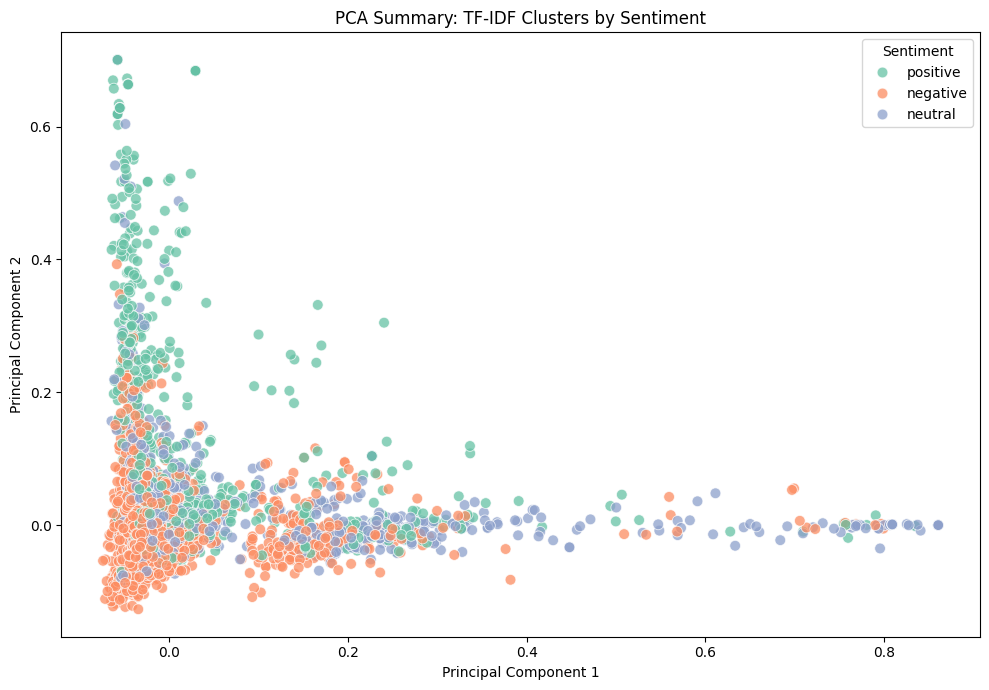

In [37]:
tfidf = grid.best_estimator_.named_steps['tfidf']
X_tfidf = tfidf.transform(X_train)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Sentiment': y_train
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Sentiment', palette='Set2', s=60, alpha=0.75)
plt.title("PCA Summary: TF-IDF Clusters by Sentiment")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

This PCA summary figure shows a two-dimensional projection of the TF-IDF features derived from the tweets in your sentiment classification task. Each point represents a tweet, and its color indicates its labeled sentiment class: positive (green), negative (orange), or neutral (purple). PCA reduces the high-dimensional TF-IDF vectors to two principal components, enabling us to visualize general structure and clustering patterns in the data.

We observe some degree of clustering, with negative tweets appearing more densely grouped near the origin, while positive and neutral tweets are more dispersed, though often overlapping. This suggests that negative sentiment tweets may share more consistent language patterns, making them easier for the model to separate. The overlap among all three classes indicates why classification errors can occur — especially between neutral and positive or neutral and negative tweets. Overall, the visualization provides insight into how the model's feature space represents the sentiment structure of the data and illustrates the challenges of multiclass classification in text-based sentiment analysis.

In [38]:
# serialize model
from joblib import dump
dump(grid, "tweets.joblib")

['tweets.joblib']

## Discussion and Conclusion

In conclusion, a Logistic Regression model was developed and tuned to classify the sentiment of airline-related tweets as positive, neutral, or negative. The model was built using a scikit-learn pipeline that combined TF-IDF vectorization with a regularized logistic classifier. Hyperparameter tuning via GridSearchCV focused on optimizing TF-IDF settings and logistic regularization strength to improve performance on multiclass classification. The final model achieved an overall test accuracy of approximately 80 percent, with particularly strong recall and precision on negative sentiment tweets. These results suggest that TF-IDF features combined with logistic regression can effectively extract and learn from patterns in customer sentiment, especially where complaints or negative expressions are prevalent.

### Key Limitations

While the model performs well overall, it demonstrates limitations in separating neutral and positive sentiment tweets, which often use overlapping vocabulary or ambiguous tones. The model also relies entirely on surface-level lexical features without understanding underlying context, sarcasm, or tone, which are crucial in sentiment analysis. Furthermore, class imbalance in the training data — where negative tweets dominate — may bias the classifier toward predicting negative sentiment more frequently. The PCA visualization also indicates that while some sentiment clusters are separable, there is still considerable overlap in feature space, contributing to misclassification in borderline cases.

### Potential Risks and Adjustments

The current model may misclassify edge cases, such as neutral tweets that carry slight emotion or positive tweets lacking strong sentiment indicators. This could pose a risk in automated sentiment tracking systems where misinterpretation could escalate service-related decisions. Additionally, logistic regression, while interpretable and efficient, assumes linear separability and may underperform in capturing nonlinear relationships embedded in natural language. Future iterations could include class rebalancing strategies, custom weighting, and advanced text preprocessing to reduce ambiguity and sparsity in feature representation.

### Improvements Needed for Practical Use

To enhance the model’s real-world usability, several improvements are recommended:

1. Introduce contextual embedding methods to better capture sentiment from word usage and sentence structure.  
2. Implement cross-domain evaluation using tweets from new time periods or industries to test generalizability.  
3. Apply ensemble methods to improve classification boundaries.  
4. Develop explainability tools to make predictions more transparent for customer support teams or sentiment analysts.  

### Conclusion

The Logistic Regression model with TF-IDF vectorization serves as a strong baseline for social media sentiment classification in airline customer feedback. The pipeline’s combination of scalable preprocessing, stratified cross-validation, and class-weighted regularization results in a robust and interpretable model that effectively captures sentiment signals in text data. Visual summaries using PCA projections further validate the model’s ability to differentiate sentiment clusters, while also highlighting areas for refinement. With continued iterations in modeling, feature engineering, and evaluation, this approach can evolve into a scalable and reliable solution for real-time sentiment monitoring across digital platforms.
